<a href="https://colab.research.google.com/github/taro-cell/Bean-Leaf-Lesions-Classification/blob/main/Bean_Leaf_Lesions_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Learning - Bean Leaf Lesions Project with pretrained VGG

**1: Datasets Download and Imports**

In [ ]:
!pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification?select=train.csv")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sugiori
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


In [ ]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os
device = "cuda" if torch.cuda.is_available() else "cpu"

**2: Preprocessing Data**

In [ ]:
#read train and test csv data
data_train = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
data_test = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

#modify file path
data_train['image:FILE'] = "/content/bean-leaf-lesions-classification/" + data_train['image:FILE']
data_test['image:FILE'] = "/content/bean-leaf-lesions-classification/" + data_test['image:FILE']

#head of data_train
data_train.head()

,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [ ]:
#head of data_test
data_test.head()

,image:FILE,category
0,/content/bean-leaf-lesions-classification/val/...,0
1,/content/bean-leaf-lesions-classification/val/...,0
2,/content/bean-leaf-lesions-classification/val/...,0
3,/content/bean-leaf-lesions-classification/val/...,0
4,/content/bean-leaf-lesions-classification/val/...,0


In [ ]:
#check the number of unique category
data_train['category'].value_counts()

,count
category,
2,348
1,345
0,341


In [ ]:
#define preprocessing pipeline
label_encoder = LabelEncoder()

transform = transforms.Compose(
    [transforms.Resize((128, 128)),
     transforms.ToTensor(),
     transforms.ConvertImageDtype(torch.float)]
)

In [ ]:
#build dataset class
class LeafLesionDataset(Dataset):
  def __init__(self, data, transform = None):
    self.data = data
    self.transform = transform
    self.labels = torch.tensor(label_encoder.fit_transform(data['category'])).to(device)

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    image_path = self.data.iloc[idx, 0]
    image = Image.open(image_path).convert("RGB")
    label = self.labels[idx]
    if self.transform:
      image = (self.transform(image)/255.0).to(device)

    return image, label

In [ ]:
#create instance of dataset
train_data = LeafLesionDataset(data_train, transform = transform)
test_data = LeafLesionDataset(data_test, transform = transform)

**3: Visualize Image to check if data is properly created**

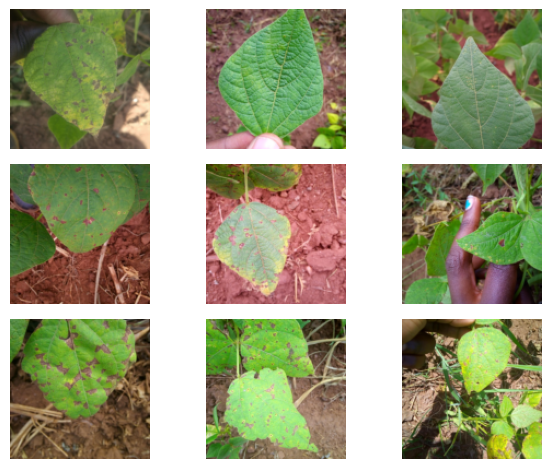

In [ ]:
n_rows = 3
n_cols = 3

f, ax = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = train_data[np.random.randint(0, train_data.__len__())][0].cpu()
    ax[row, col].imshow((image*255).squeeze().permute(1,2,0))
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()

**5: Hyperparameters**

In [ ]:
#learning rate, batch_size and epochs
lr = 1e-3
batch_size = 4
epochs = 10

In [ ]:
#load train and test dataset
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

### **Google Net**

In [ ]:
#load googlenet
googlenet_model = models.googlenet(weights= 'DEFAULT')

#unfreeze all parameters
for param in googlenet_model.parameters():
  param.requires_grad = True

In [ ]:
#change the last layer
num_labels = len(data_train['category'].unique())
googlenet_model.fc = nn.Linear(in_features = 1024, out_features = num_labels)

In [ ]:
#check all parameters of the googlenet model
googlenet_model.to(device)
summary(googlenet_model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
       BasicConv2d-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
       BasicConv2d-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 192, 32, 32]         110,592
       BatchNorm2d-9          [-1, 192, 32, 32]             384
      BasicConv2d-10          [-1, 192, 32, 32]               0
        MaxPool2d-11          [-1, 192, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          12,288
      BatchNorm2d-13           [-1, 64, 16, 16]             128
      BasicConv2d-14           [-1, 64,

In [ ]:
#define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr = lr)

**6: Train model**

In [ ]:
total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(epochs):
  total_acc_train = 0
  total_loss_train = 0

  for (inputs, labels) in train_loader:
    optimizer.zero_grad()
    outputs = googlenet_model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, dim = 1) == labels).sum().item()
    total_acc_train += train_acc

    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_data.__len__())*100, 4))
  print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(train_data.__len__())*100):.4f}%''')

Epoch no. 1 Train Loss: 0.2500 Train Accuracy: 53.8685%
Epoch no. 2 Train Loss: 0.2281 Train Accuracy: 61.3153%
Epoch no. 3 Train Loss: 0.2002 Train Accuracy: 67.3114%
Epoch no. 4 Train Loss: 0.1864 Train Accuracy: 70.1161%
Epoch no. 5 Train Loss: 0.1779 Train Accuracy: 71.3733%
Epoch no. 6 Train Loss: 0.1712 Train Accuracy: 70.7930%
Epoch no. 7 Train Loss: 0.1691 Train Accuracy: 73.9845%
Epoch no. 8 Train Loss: 0.1469 Train Accuracy: 77.0793%
Epoch no. 9 Train Loss: 0.1354 Train Accuracy: 79.3037%
Epoch no. 10 Train Loss: 0.1270 Train Accuracy: 79.5938%


**7: Check the performance on test data**

In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = googlenet_model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_data.__len__())*100, 2)}%")

Accuracy Score is: 80.45%


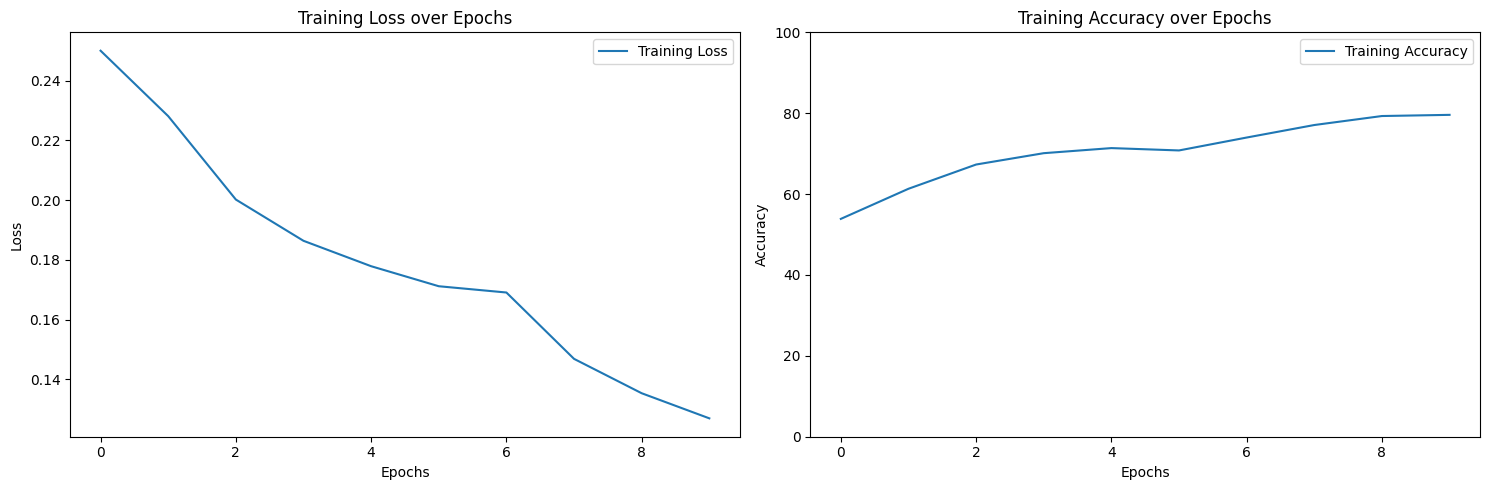

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

### **VGG-16**

In [ ]:
#load pretrained VGG-16
vgg_model = models.vgg16(weights= 'DEFAULT')

In [ ]:
#unfreeze all layers
for param in vgg_model.parameters():
  param.requires_grad = True

In [ ]:
#number of labels
num_labels = len(data_train['category'].unique())

#change the last layer
vgg_model.classifier[-1] = nn.Linear(in_features = 4096, out_features = num_labels)

#move the model to device
vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
#check the number of parameters of each layer
vgg_model = vgg_model.to(device)
summary(vgg_model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

In [ ]:
#define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(vgg_model.parameters(), lr = lr)

**6: Train Model**

In [ ]:
total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(epochs):
  total_acc_train = 0
  total_loss_train = 0

  for (inputs, labels) in train_loader:
    optimizer.zero_grad()
    outputs = vgg_model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, dim = 1) == labels).sum().item()
    total_acc_train += train_acc

    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_data.__len__())*100, 4))
  print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(train_data.__len__())*100):.4f}%''')

Epoch no. 1 Train Loss: 0.3064 Train Accuracy: 30.4642%
Epoch no. 2 Train Loss: 0.2904 Train Accuracy: 35.6867%
Epoch no. 3 Train Loss: 0.2887 Train Accuracy: 32.7853%
Epoch no. 4 Train Loss: 0.2879 Train Accuracy: 30.6576%
Epoch no. 5 Train Loss: 0.2873 Train Accuracy: 34.9130%
Epoch no. 6 Train Loss: 0.2888 Train Accuracy: 31.8182%
Epoch no. 7 Train Loss: 0.2874 Train Accuracy: 33.7524%
Epoch no. 8 Train Loss: 0.2885 Train Accuracy: 32.8820%
Epoch no. 9 Train Loss: 0.2880 Train Accuracy: 31.4313%
Epoch no. 10 Train Loss: 0.2864 Train Accuracy: 34.4294%


**7: Check the performance on test data**

In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = vgg_model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_data.__len__())*100, 2)}%")

Accuracy Score is: 36.09%


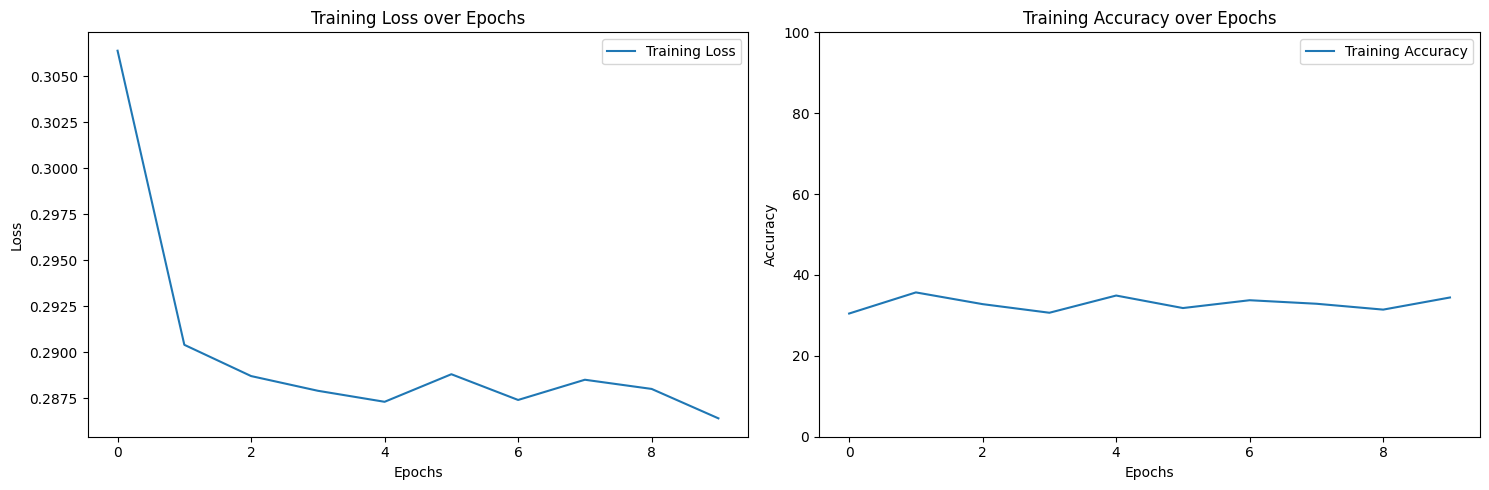

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()